In [1]:
import os
import cv2
import h5py
import numpy
from PIL import Image
import prepare_data as pd
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import adam
from keras.layers.merge import concatenate, add
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation

Using TensorFlow backend.


In [2]:
#TRAINING DATA PREPARATION
DATA_PATH = "yang91/"
Random_Crop = 10
Patch_size = 12
label_size = 96
scale = 8


def prepare_training_data():
    names = os.listdir(DATA_PATH)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = DATA_PATH + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # produce Random_Crop random coordinate to crop training img
        if(min(shape[0], shape[1]) - label_size < 0):
            continue
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)

        for j in range(Random_Crop):
            hr_patch = hr_img[Points_x[j]: Points_x[j] + label_size, Points_y[j]: Points_y[j] + label_size]
            lr_patch = cv2.resize(hr_patch, (label_size // scale, label_size // scale), cv2.INTER_CUBIC)

            lr_patch = lr_patch.astype(float) // 255.
            hr_patch = hr_patch.astype(float) // 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label


if __name__ == "__main__":
    data, label = prepare_training_data()
    write_hdf5(data, label, "AYE_TRAINING_FILE.h5")
    # _, _a = read_training_data("train.h5")
    # _, _a = read_training_data("test.h5")

In [3]:
def model_AYE():
    _input = Input(shape=(None, None, 1), name='INPUT_LR_IMAGE')
    
    #FIRST LAYER IS USED TO EXTRACT THE FEATURES
    C1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',name='FIRST_LAYER')(_input)
    
    #UPSAMPLING LAYER
    U = Conv2DTranspose(filters=4, kernel_size=(14, 14), strides=(scale,scale),padding='same', activation='relu',name='UPSCALE_LAYER')(C1)
     
    # ****BLOCK1***********
    MAIN_NODE_1 = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu',name='MAIN_NODE_1')(U)
    
    
    Branch1a = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1),padding='same', activation='relu',name='BRANCH_1a')(MAIN_NODE_1)
    Branch1b = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),padding='same', activation='relu',name='BRANCH_1b')(MAIN_NODE_1)
    Branch1c = Conv2D(filters=16, kernel_size=(5,5), strides=(1, 1),padding='same', activation='relu',name='BRANCH_1c')(MAIN_NODE_1)
    
    
    # ****CONCATENATION NODE***********
    Concatenate1 = concatenate(inputs=[Branch1a, Branch1b, Branch1c])
    out1 = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu',name='OUTPUT_LAYER_1')(Concatenate1)
    
    
    # ****BLOCK2***********
    MAIN_NODE_2 = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu',name='MAIN_NODE_2')(out1)
    
    
    Branch2a = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1),padding='same', activation='relu',name='BRANCH_2a')(MAIN_NODE_2)
    Branch2b = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),padding='same', activation='relu',name='BRANCH_2b')(MAIN_NODE_2)
    Branch2c = Conv2D(filters=16, kernel_size=(5,5), strides=(1, 1),padding='same', activation='relu',name='BRANCH_2c')(MAIN_NODE_2)
    
    
    # ****CONCATENATION NODE***********
    Concatenate2 = concatenate(inputs=[Branch2a, Branch2b, Branch2c])
    out2 = Conv2D(filters=1, kernel_size=(1, 1), strides=(1,1), padding='same', activation='relu',name='OUTPUT_LAYER_2')(Concatenate2)
        
    model = Model(input=_input, output=out2)

    return model

In [4]:
AYE = model_AYE()

C:\Users\user\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("IN..., outputs=Tensor("OU...)`


In [5]:
AYE.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT_LR_IMAGE (InputLayer)     (None, None, None, 1 0                                            
__________________________________________________________________________________________________
FIRST_LAYER (Conv2D)            (None, None, None, 6 640         INPUT_LR_IMAGE[0][0]             
__________________________________________________________________________________________________
UPSCALE_LAYER (Conv2DTranspose) (None, None, None, 4 50180       FIRST_LAYER[0][0]                
__________________________________________________________________________________________________
MAIN_NODE_1 (Conv2D)            (None, None, None, 1 80          UPSCALE_LAYER[0][0]              
____________________________________________________________________________________________

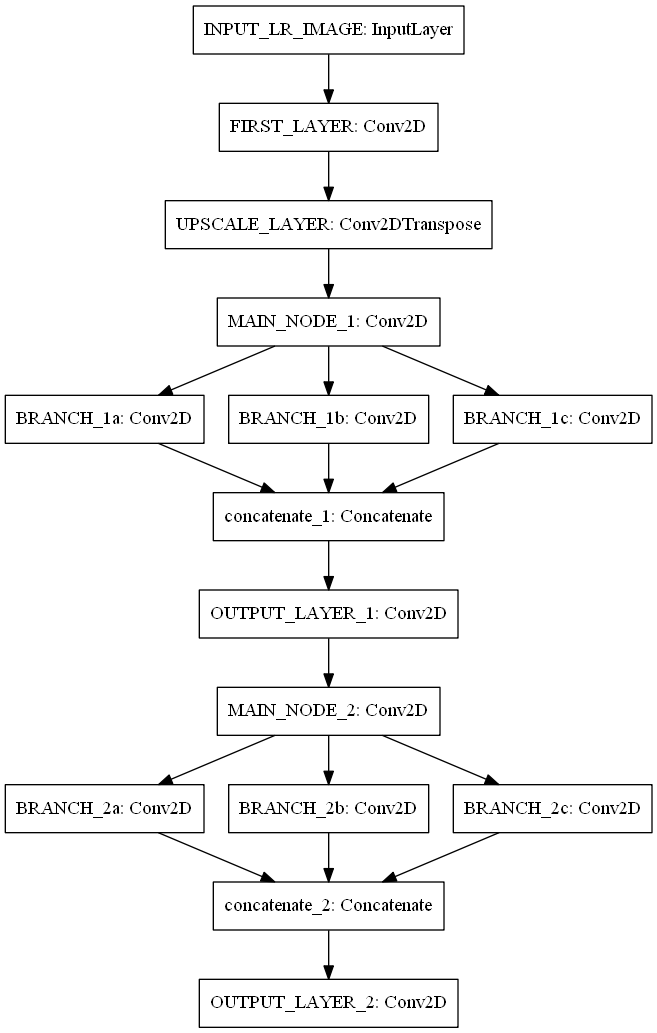

In [6]:
import tensorflow as tf
tf.keras.utils.plot_model(AYE, 'AYE_PROPOSED_MODEL.png')

In [ ]:
def AYE_train():
    AYE = model_AYE()
    AYE.compile(optimizer=adam(lr=0.0003), loss='mse')
    data, label = pd.read_training_data("AYE_TRAINING_FILE.h5")
    AYE.fit(data, label, batch_size=32, epochs=20)
    AYE.save_weights("AYE_MODEL_SCALE_2TESTING_FILE.h5")

    
def AYE_predict():
    AYE = model_AYE()
    AYE.load_weights("AYE_MODEL_SCALE_2TESTING_FILE.h5")
    IMG_NAME = "bird_GT.png"
    INPUT_NAME = "INPUT_LOW_RESOLUTION_IMAGE.png"
    OUTPUT_NAME = "MODEL_OUTPUT_IMAGE.png"
    
    
    
    import cv2
    img = cv2.imread(IMG_NAME)
    shape = img.shape
    img = cv2.resize(img, (shape[1] // scale, shape[0] // scale), cv2.INTER_CUBIC)
    cv2.imwrite(INPUT_NAME, img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1))
    Y[0, :, :, 0] = img[:, :, 0]
    img = cv2.resize(img, (shape[1], shape[0]), cv2.INTER_CUBIC)

    pre = AYE.predict(Y, batch_size=1)
    pre[pre[:] > 255] = 255
    pre = pre.astype(numpy.uint8)
    img[:, :, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)
    
    im2 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)

    
    print ("AYE_MODEL:")
    print (cv2.PSNR(im1, im2))


if __name__ == "__main__":
    AYE_train()
    AYE_predict()

C:\Users\user\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("IN..., outputs=Tensor("OU...)`


Epoch 1/20
2910/2910 [==============================] - 5s 2ms/step - loss: 0.0031
Epoch 2/20
2910/2910 [==============================] - 2s 828us/step - loss: 0.0031
Epoch 3/20
2910/2910 [==============================] - 2s 855us/step - loss: 0.0031
Epoch 4/20
2910/2910 [==============================] - 3s 866us/step - loss: 0.0031
Epoch 5/20
2910/2910 [==============================] - 3s 864us/step - loss: 0.0031
Epoch 6/20
2910/2910 [==============================] - 3s 862us/step - loss: 0.0031
Epoch 7/20
2910/2910 [==============================] - 3s 862us/step - loss: 0.0031
Epoch 8/20
2910/2910 [==============================] - 3s 865us/step - loss: 0.0031
Epoch 9/20
2910/2910 [==============================] - 3s 881us/step - loss: 0.0031
Epoch 10/20
2910/2910 [==============================] - 3s 875us/step - loss: 0.0031
Epoch 11/20
2910/2910 [==============================] - 3s 875us/step - loss: 0.0031
Epoch 12/20
2910/2910 [==============================] - 3s 881us

In [ ]:
Bicubic = cv2.imread('INPUT_LOW_RESOLUTION_IMAGE.png',cv2.IMREAD_COLOR)
bicubic_img = cv2.resize(Bicubic,None, fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC)
cv2.imwrite('bicubic.png',bicubic_img)

In [ ]:
GT_IMAGE = Image.open("bird_GT.png")############################################################
LR_IMAGE = Image.open("INPUT_LOW_RESOLUTION_IMAGE.png")
Bicubic_Upscale = Image.open("bicubic.png")
MODEL_IMAGE = Image.open("MODEL_OUTPUT_IMAGE.png")

In [ ]:
fig = plt.figure(figsize =(14,14),dpi=100)
ax = plt.subplot("141")
ax.imshow(GT_IMAGE)
ax.set_title('ORIGINAL GT IMAGE')
plt.axis('off')

ax = plt.subplot("142")
ax.imshow(LR_IMAGE)
ax.set_title('LR IMAGE IMAGE')
plt.axis('off')

ax = plt.subplot("143")
ax.imshow(Bicubic_Upscale)
ax.set_title('BICUBIC_UPSCALE_IMAGE')
plt.axis('off')

ax = plt.subplot("144")
ax.imshow(MODEL_IMAGE)
ax.set_title('AYE_MODEL_OUTPUT_IMAGE')
plt.axis('off')

In [ ]:
img1 = cv2.imread('bird_GT.png', cv2.IMREAD_UNCHANGED)
cv2.imshow('GT_Image',img1)

img2 = cv2.imread('INPUT_LOW_RESOLUTION_IMAGE.png', cv2.IMREAD_UNCHANGED)
cv2.imshow('4X_LRIMAGE',img2)

img3 = cv2.imread('bicubic.png', cv2.IMREAD_UNCHANGED)
cv2.imshow('BICUBIC_UPSCALE_IMAGE',img3)

img4 = cv2.imread('MODEL_OUTPUT_IMAGE.png', cv2.IMREAD_UNCHANGED)
cv2.imshow('MODEL_IMAGE',img4)

cv2.waitKey(0) #image will not show until this is called
cv2.destroyAllWindows() #make sure window closes cleanly